In [4]:
import torch
from torch import nn, optim

from fastpolyhedra import cx

import matplotlib.pyplot as plt
from timeit import default_timer as timer

## Obtaining C(F) for a network

In [5]:
#select architecture
architecture = [2,10,10,1]

#randomly initialize neural network with this architecture
model = cx.DeepNeuralNetwork(architecture) 

#obtain polyhedral complex associated with this model
plot_dictionary, ss_vertices, vertices = cx.get_full_complex(model, max_depth=3, verbose=True)

#The warning here is due to a problem with torch.combinations in this version of pytorch.

First Layer Complete
Next Layer Beginning. 
100 edges to evaluate ... 
*********************   100.00%
finding intersections of 2 new hyperplanes with 0 old hyperplanes
********************   97.73%
 Layer 2 complete.
Next Layer Beginning. 
353 edges to evaluate ... 
*********************   100.00%

 Layer 3 complete.


## Plotting a decision boundary for 2-d inputs

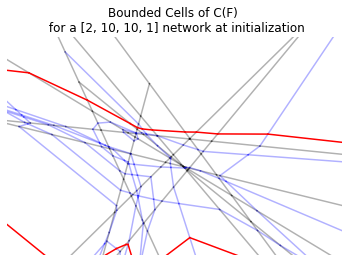

In [6]:
# set plotting parameters
colors = ['black']*architecture[1]+['blue']*architecture[2] + ['red']
alphas = [0.3]*(architecture[1]+architecture[2])+[1]
bound = 5

# initialize figures
fig,ax = plt.subplots()

# plotting script
cx.plot_fast(vertices, 
            plot_dictionary, 
            colors = colors, 
            ax = ax,
            alphas=alphas,
            bound = bound)

#additional formatting
ax.set_title("Bounded Cells of C(F) \n for a {} network at initialization".format(architecture))
ax.set_axis_off()
    
plt.show()

# Plotting a decision boundary in 3-d

Here, we train a model to separate a torus from an annulus at its center, meaning an appropriately-trained network will have a toroidal decision boundary. The following parameters work a good proportion of the time. A trained network will typically have a loss less than 0.001.

In [7]:
# obtain (normalized) torus dataset 

valpoints,vallabels=cx.make_torus(1000) 
valpoints*=.25

#select architecture and initialize model 

architecture = (3,15,15,1)
model = cx.DeepNeuralNetwork(architecture)

criterion = nn.BCELoss()

lr=.01
sample_size = 30

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
model.to('cpu')

for training_step in range(40000):
    
    points,labels = cx.make_torus(sample_size)
    points=points*.25
    optimizer.zero_grad()
    
    _,_,outputs = model(points)
    
    
    loss = criterion(torch.sigmoid(outputs), labels)
    
    loss.backward()
    optimizer.step()
    
    if training_step%5000==0: 
        
        
        lr *= .95
        sample_size += 5
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        _,_,outputs = model(valpoints)
        temploss = criterion(torch.sigmoid(outputs),vallabels)
        print("Current loss: ", temploss.item(), end="\r")
                
        

## Obtaining polyhedral complex (3d inputs)
Here we obtain the polyhedral complex. If you have a slow CPU, making it verbose can lead to glitches. 


In [8]:

plot_dictionary, ss_vertices, vertices = cx.get_full_complex(model, max_depth=3,verbose=True)


First Layer Complete
Next Layer Beginning. 
1470 edges to evaluate ... 
*********************   100.00%
finding intersections of 2 new hyperplanes with 1 old hyperplanes
finding intersections of 3 new hyperplanes with 0 old hyperplanes
********************   98.25%
 Layer 2 complete.
Next Layer Beginning. 
14499 edges to evaluate ... 
*********************   100.00%

 Layer 3 complete.


(-1.0, 1.0)

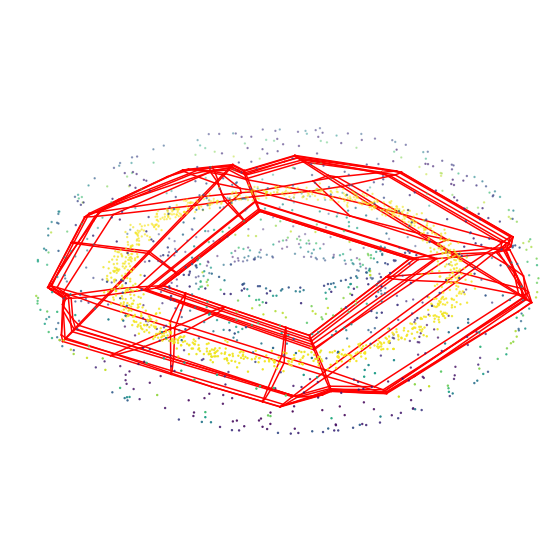

In [9]:
# plotting a 3d decision boundary 

#Initializing figure 
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection='3d')

ax.scatter(*valpoints.T, c=model(valpoints)[2].detach().numpy(),s=2)

cx.plot_fast(vertices, plot_dictionary, ax=ax)

#format 
ax.set_axis_off()

bound=1

ax.set_xlim(-bound,bound)
ax.set_ylim(-bound,bound)
ax.set_zlim(-bound,bound)

plt.show()